<a href="https://colab.research.google.com/github/calvin-bales/Lectures/blob/main/2600_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Calvin Bales\
Physics 2600 Final Project\
Calculating the power output of an array of solar cells

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.geocoders import Nominatim
import pytz
from pytz import timezone
import pandas as pd
from scipy.integrate import odeint

In quote marks below, enter adress where the solar cells are located. For the purposes of this project, we'll assume that they are located at all our favorite location, Barus and Holley.

In [3]:
geolocator = Nominatim()
loc = geolocator.geocode("Barus and Holley Providence RI")
print(loc.address)
print((loc.latitude, loc.longitude))

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


Barus & Holley, 184, Hope Street, Fox Point, Providence, Providence County, Rhode Island, 02912, United States
(41.826550850000004, -71.39789914885344)


To begin, we will define the parameters necessary to calculate the solar time. Solar time is like normal time except that it's purely dependent of the angles of the sun relative to the position on Earth. Since we're calculating solar irradiance (amount of sun that hits Earth), it's useful to think about time in terms of the position of the sun as opposed the the socially constructed time we're accustomed to. 

In [4]:
#sets the local time. since we're interested in observing the power over many hours, we don't just want to know the current time
def local_time(start, end): #give start hour and end hour  
  hour_list = np.arange(start, end+1)
  minute_list = np.arange(start*60, (end+1)*60) 
  return hour_list, minute_list

#defines the time difference between EST/EDT and GMT (Greenwich Mean Time)
def tz_diff(date, tz1, tz2): #give the difference between two time zones (for us, GMT and EST or EDT depending on time of year)
    date = pd.to_datetime(date)
    return (tz1.localize(date) - tz2.localize(date).astimezone(tz1)).seconds/3600

#calculates declination angle
def delta(g): #takes doy
  x = (360/365)*(g-81)
  return 23.45*np.sin(np.radians(x)) #degrees

#equation of time (how much slower or faster solar time is due to non-constant rate of rotation of earth)
def EoT(d): #takes doy
  x = (360/365)*(d-81)
  return 9.87*np.sin(np.radians(2*x))-7.53*np.cos(np.radians(x))-1.5*np.sin(np.radians(x)) 

#calculates solar time
# def solar_time(i, E): # current time (minutes) and EoT (minutes)
#   std_mer = (t_diff*15) #degress 
#   local_mer = loc.longitude #degrees 
#   return i + (std_mer-local_mer)*4 + E #minutes
def solar_time(i, l, e):
  return i + e + 4*l - 60*(-4)


#calculates solar hour
def omega(j): # solar time 
  j = j/60
  return (j-12)*15 #degrees

#calculates zenith angle
def zenith(a, b, c): #latitude, declination, solar angle (omega)
  z = np.cos(np.radians(a))*np.cos(np.radians(b))*np.cos(np.radians(c))+ np.sin(np.radians(a))*np.sin(np.radians(b))
  return np.degrees(np.arccos(z))

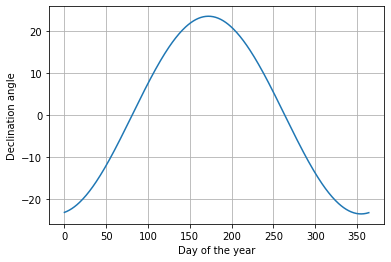

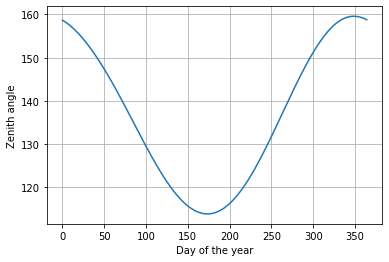

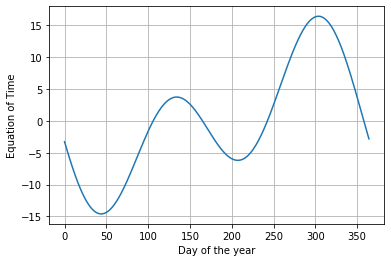

In [5]:
doy = datetime.now().timetuple().tm_yday #defines the day of the year (jan 1 = 1, dec 31 = 365)
phi = loc.latitude #gets latitude of position entered at top

gmt = timezone('GMT')
est = timezone('America/New_York')
t_diff = tz_diff(doy, est, gmt)-1 #-1 because we're on dst
std_mer = t_diff*15
local_mer = loc.longitude

# plot declination angle verses time of year
x = np.arange(0, 365)
y = delta(x)
plt.plot(x,y)
plt.xlabel("Day of the year")
plt.ylabel("Declination angle")
plt.grid()
plt.show()

d = delta(x)
t = x*24*60*60 #convert day to minutes for a year
# solar_t = solar_time(t, EoT(x))
solar_t = solar_time(t, loc.longitude, EoT(x))
w = omega(solar_t)
zen = zenith(phi, d, w)


#plot zenith angle over the course of a year
plt.plot(t/24/60/60, zen)
plt.xlabel("Day of the year")
plt.ylabel("Zenith angle")
plt.grid()
plt.show()

#plot of equaiton of time over year
plt.plot(x, EoT(x))
plt.xlabel("Day of the year")
plt.ylabel("Equation of Time")
plt.grid()
plt.show()

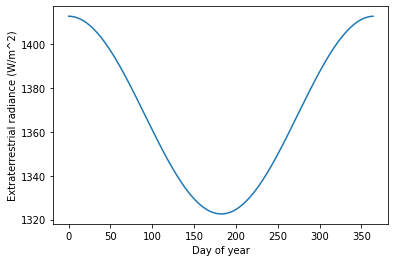

Text(0, 0.5, 'Global Horizontal Irradiance (W/m^2)')

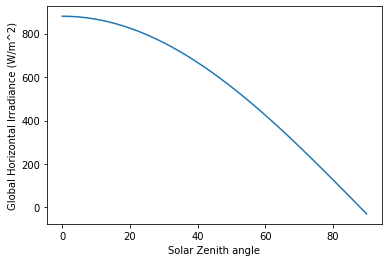

In [6]:
#calculate extraterrestrial radiation
def irr0(n): #takes date
  arg = (2*np.pi/365)*n
  return 1367.7*(1+0.033*np.cos(arg))

def GHI(z): #takes zenith angle
  return 910*np.cos(z)-30

x = np.arange(0, 365)
y = irr0(x)
plt.plot(x,y)
plt.xlabel("Day of year")
plt.ylabel("Extraterrestrial radiance (W/m^2)")
plt.show()
zen = np.linspace(0,np.pi/2, 1000)
plt.plot(np.degrees(zen), GHI(zen))
plt.xlabel("Solar Zenith angle")
plt.ylabel("Global Horizontal Irradiance (W/m^2)")

Calculate sunrise, sunset, and total daylight hours

In [6]:
#hour angle of sunrise/sunset
def ah(d, l): #takes delta (declination angle) and lattitude
  f = np.cos(np.radians(90.833))/(np.cos(np.radians(l))*np.cos(np.radians(d)))
  g = np.tan(np.radians(l))*np.tan(np.radians(d))
  return np.arccos(f-g)

#sunrise
def lds(h, l, s): #hour angle, longitude, equation of time 
  return 720 - 4*(l+h)-s

#sunset 
def cds(h, l, s): #hour angle, longitude, equation of time 
  return 720 - 4*(l-h)-s


ha = np.degrees(ah(delta(doy), loc.latitude))
sr = lds(ha, loc.longitude, EoT(doy))-4*60
ss = cds(ha, loc.longitude, EoT(doy))-4*60
daylight = ss-sr

print(sr)
print(ss)
print(daylight)

378.87251653528233
1156.690777808885
777.8182612736027


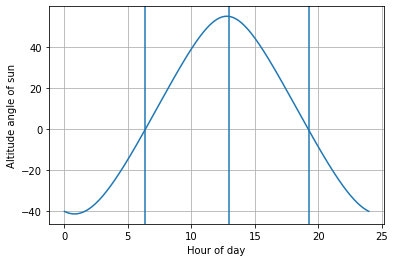

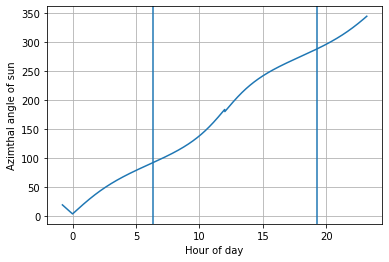

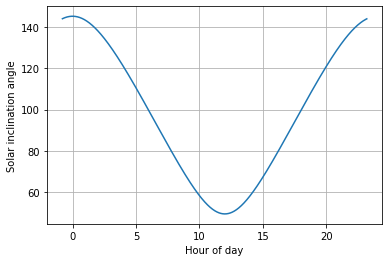

In [7]:
#altitude angle of sun in the sky
def sol_alt(l,d,o): #latitude, delta, omega
  r = np.sin(np.radians(l))*np.sin(np.radians(d))
  u = np.cos(np.radians(l))*np.cos(np.radians(d))*np.cos(np.radians(o))
  return np.degrees(np.arcsin(r+u))

def sol_azimuth(l, z, d):
  num = np.sin(np.radians(l))*np.cos(np.radians(z))-np.sin(np.radians(d))
  den = np.cos(np.radians(l))*np.sin(np.radians(z))
  return np.degrees(np.arccos(num/den))

#sun's incident angle of the solar panels
def sol_inc(b, z, asol, am): #takes tilt of panels (0=flat), zenith angle of sun, azimuthal angle of sun, azimuthal angle of panels (N=0deg, E=90deg)
  k = np.cos(np.radians(b))*np.cos(np.radians(z))+np.sin(np.radians(b))*np.sin(np.radians(z))*np.cos(np.radians(asol-am))
  return np.degrees(np.arccos(k))

delt = delta(doy)
phi = loc.latitude
temps = np.arange(0, 1440)
solar_tday = solar_time(temps, loc.longitude, EoT(doy))
wday = omega(solar_tday)
zenday = zenith(phi, delt, wday)

alt = sol_alt(phi, delt, wday)

azi = sol_azimuth(loc.latitude, zenday, delt)
for i in range(len(wday)):
  if wday[i]>0:
    azi[i] = (azi[i]+180)%360
  else:
    azi[i] = (544-azi[i])%360

inc = sol_inc(15, zenday, azi[0], 180)

plt.plot(temps/60, alt)
plt.xlabel("Hour of day")
plt.ylabel("Altitude angle of sun")
plt.axvline(x=sr/60)
plt.axvline(x=ss/60)
plt.axvline(x=daylight/60)
plt.grid()
plt.show()
plt.plot(solar_tday/60, azi)
plt.axvline(x=sr/60)
plt.axvline(x=ss/60)
plt.xlabel("Hour of day")
plt.ylabel("Azimthal angle of sun")
plt.grid()
plt.show()
plt.plot(solar_tday/60, inc)
plt.xlabel("Hour of day")
plt.ylabel("Solar inclination angle")
plt.grid()
plt.show()

In [8]:
#load files
import google.colab
# from google.colab import files  # Using the files method in example below

# Ask for file selection on your laptop
print("You should choose a file from your machine to upload to the Colab virtual machine\n")
uploaded = google.colab.files.upload()

print("\n")
for fn in uploaded.keys():
  print(
    'User uploaded file "{name}" with length {length} bytes is now in /content/ directory'.format(
      name=fn, length=len(uploaded[fn]))
  )

# A simple *unix command tto the shell ! that lists the directory contents
!ls "/content/"


You should choose a file from your machine to upload to the Colab virtual machine





sample_data


In [ ]:
data = np.genfromtxt(fn, delimiter=',') 
# azi_day_noaa = data[:,0]
# z_day_noaa = data[:,0]
solt_noaa = data[:,0]
# zen_noaa = data[:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


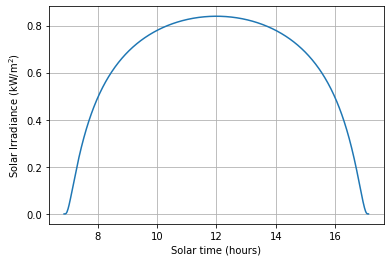

In [9]:
def sol_irr(ang):
  AM = (1/np.cos(np.radians(ang)))**0.678
  return 1.353*0.7**AM


plt.plot(solar_tday/60, sol_irr(inc))
plt.ylabel("Solar Irradiance (kW/m$^2$)")
plt.xlabel("Solar time (hours)")
plt.grid()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


(6.3145419422547056, 19.278179630148085)

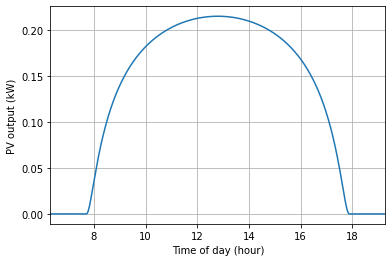

In [10]:
# calculating solar panel output
sun = np.nan_to_num(sol_irr(inc)) #changes nan (values before sunrise and after sunset) to zeros 

def PVout(T, G, C=0.285, D=0.9, a=-0.0028): 
  k = 0.03
  Tc = G*k+T 
  Tsct = k + T
  return C*D*(1+a*(Tc-Tsct))*G

tot_irr = np.sum(sun)
#print(tot_irr)

out_power = PVout(17, sun)
plt.plot(temps/60, out_power)
plt.grid()
plt.xlabel("Time of day (hour)")
plt.ylabel("PV output (kW)")
plt.xlim(sr/60, ss/60)

CLOUDS

In [30]:
def day_T(low, high): #takes degrees C
  a = np.linspace(low, high, int(1440/2))
  b = np.linspace(high, low, int(1440/2))
  return [*a, *b]

#actual vapor pressure takes dew point temperature, saturated vapor pressure takes air temperature
def vap_P(T, L): #e(dew temp, latent heat) or e_s(temperature, latent heat) 
  R_v = 461 #J/kgK
  T = T+273.3 #C to K
  delt_T = (1/T)-(1/273.3)
  exponent = (L/R_v)*delt_T
  return 6.113**exponent

#actual mixing ratio takes actual vapor pressure, saturated mixing ratio takes saturation vapor pressure. Both take pressure (mbar)
def mix_ratio(e, P): #rv
  return 0.622*e/(P-e)

def air_density(T, P, vap): #takes tempreature[C], pressure [millibar] and vapor pressure [millibar]
  R = 8.3145 #J/Kmol (universal gas constant)
  Ma = 0.0289 #kg/mol (molar mass of dry air)
  Mv = 0.018 #kg/mol (molar mass of water vapor)
  P = P*100 #mb to Pa
  vap = vap*100
  Pa = P - vap
  T += 273.3 #C to K
  return (Pa*Ma+vap*Mv)/(R*T)

def amount(d, r): #takes density and mixing ratio [kg/m^3] -- q
  return d*r

In [31]:
#mixing ratio of cloud liquid rate of change
def dcloud_mix(rc, rv, rls, t):
  return 0.75*(rv-rls)

#mixing ratio of water vapor rate of change 
def dvap_mix(rv, rls, t):
  return -0.75*(rv-rls)

#cloud ice mass nucleated in each time step
def ci_mass(rv, ris, t):
  mp = 10**(-11) #kg
  return 1000*mp*np.exp(-0.639+12.96*((rv/ris) -1))

#cloud crystal growth rate
def grow_cc(qv, qis, qp):
  Cvp = 25
  return Cvp*(qv-qis)*qp

#rain production rate
def make_rain(qr, qc):
  Ccr = 17
  return Ccr*qr*qc

#evaporation rate
def evap_rain(rls, rv):
  Crv = 10**-3
  return -Crv*(rls-rv)

#fall velocity
def FV(rr, rho):
  return 13*(rr**0.125)*(rho**-0.5)

In [39]:
#define current conditions or conditions for calculation
T = 17
T_d = 4
Pressure = 1016

#calculate r_v and r_ls
e = vap_P(T, 2.5e6) 
rv = mix_ratio(e, Pressure)
es = vap_P(T_d, 2.5e6)
rls = mix_ratio(es, Pressure)
esi = vap_P(T_d, 2.38e6)
ris = mix_ratio(esi, Pressure)

#set time range
time = local_time(0, 23)[0]


In [40]:
#####START OF FLOW CHART#####

if rv>ris:
  if rv>rls:
    print("Condensate excess vapor to liquid")
  else:
    print("rv>ris, evaporate liquid")
else:
  print("rv<ris, evaporate liquid")
print("saturated vapor mixing ratio = ", round(rls, 5))
print("mixing ratio of vapor = ", round(rv,5))
print("saturated ice mixing ratio = ", round(ris,5))

rv<ris, evaporate liquid
saturated vapor mixing ratio =  0.00036
mixing ratio of vapor =  7e-05
saturated ice mixing ratio =  0.00037


In [41]:
#####Condensate excess vapor to liquid#####



In [46]:
#####Evaporate liquid#####
rain_rate = evap_rain(rls, rv)
print(rain_rate)
rv1 = rls-rain_rate/(2*0.75)
print(rv1)

-2.9013999931323974e-07
0.00036503526661223694


In [14]:
def RK4(rv, rls, rc, start, end, N):
    time = np.linspace(start,end,N)
    h = (end-start)/N
    mixing_water = []
    mixing_cloud = []
    for t in time:
        if t==0:
            rv=rv
            rc=rc
        else:
            k1 = h*drv(rv, rls, t)
            k2 = h*drv(rv+k1/2, rls, t+h/2)
            k3 = h*drv(rv+k2/2, rls, t+h/2)
            k4 = h*drv(rv+k3, rls, t+h)
            rv += (k1+2*k2+2*k3+k4)/6
            
            k1b = h*drc(rv, rls, rc, t)
            k2b = h*drc(rv, rls, rc+k1b/2, t+h/2)
            k3b = h*drc(rv, rls, rc+k2b/2, t+h/2)
            k4b = h*drc(rv, rls, rc+k3b, t+h)
            rc += (k1b+2*k2b+2*k3b+k4b)/6
        mixing_water.append(rv)
        mixing_cloud.append(rc)
    mixing_water = np.array(mixing_water)
    mixing_cloud = np.array(mixing_cloud)
    time = np.array(time)
    return time, mixing_water, mixing_cloud 


In [ ]:
T = 17 #current temperature [C]
T_dew = 2 #dew point [C]
P = 1012 #mBar 

rls = vap_P(T, 2.5e6)
rv = mix_ratio(rls, P)
print(rv)
rate = RK4(rv, rls, 7, 0, 12, 1000)

plt.plot(rate[0], rate[1])
plt.grid()